In [15]:
import ocpy


In [16]:
# from ocpy import OCP, DDPSolver, iLQRSolver
from ocpy import OCP
from ocpy import UCRRSolver
from ocpy import symutils

import numpy as np
import sympy as sym
from sympy import sin, cos, tan, exp, log, ln, sinh, cosh, tanh, diff, sqrt
from IPython.display import display, Math


In [17]:
# Dimensions of state and input
n_x = 4
n_u = 1
sim_name = 'cartpole'
# Define ocp class
ocp = OCP(n_x, n_u, sim_name)
# Get symbols
t = ocp.get_t()
x = ocp.get_x()
u = ocp.get_u()


In [18]:
# Symbolic expressions of constants.
m_c, m_p, l, g, u_min, u_max, u_eps = ocp.define_scalar_constants(
         [('m_c', 2), ('m_p', 0.1), ('l', 0.5), ('g', 9.80665), 
          ('u_min', -15),  ('u_max', 15), ('u_eps', 0.001)]
          )
# Cost weight
q = ocp.define_vector_constant('q', [2.5, 10, 0.01, 0.01])
r = ocp.define_vector_constant('r', [1])
q_f = ocp.define_vector_constant('q_{f}', [2.5, 10, 0.01, 0.01])
Q = symutils.diag(q)
Q_f = symutils.diag(q_f)
R = symutils.diag(r)
# Reference state. 
x_ref = ocp.define_vector_constant('x_{ref}', [0, np.pi, 0, 0])


In [19]:
# State of equation.
f = ocp.get_zero_vector(n_x)
f[0] = x[2]
f[1] = x[3]
f[2] = (u[0] + m_p*sin(x[1])*(l*x[1]*x[1] + g*cos(x[1])) )/( m_c+m_p*sin(x[1])*sin(x[1]) )
f[3] = (-u[0] * cos(x[1]) - m_p*l*x[1]*x[1]*cos(x[1])*sin(x[1]) 
        - (m_c+m_p)*g*sin(x[1]) )/( l*(m_c + m_p*sin(x[1])*sin(x[1])))
# Log barrier for control limits.
u_barrier = sym.Matrix([sum(-ln(u[i] - u_min) - ln(u_max - u[i]) for i in range(n_u))*1e-5])
# Stage cost and terminal cost.
l = (x - x_ref).T * Q * (x - x_ref) + u.T * R * u #+ u_barrier
lf = (x - x_ref).T * Q_f * (x - x_ref)
# Display state equation and cost function
display(Math(r"\dot{x} = f(x, u, t) \equiv %s" % sym.latex(f)))
display(Math(r"l(x, u) = %s" % sym.latex(l)))
display(Math(r"l_f(x) = %s" % sym.latex(lf)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
# Horizon length and discretization grids.
T = 5.0
N = 200
# Initial condition
t0 = 0.0
x0 = np.array([0.0, 0.0, 0.0, 0.0])

# Define ocp
ocp.define_unconstrained(f, l, lf, t0, x0, T, N)


In [21]:
solver = UCRRSolver(ocp)

us_guess = np.zeros((N, n_u))
xs_guess = np.tile(x0, (N + 1, 1))
# lmds_guess = np.zeros((N + 1, n_x))

# solver.set_guess(xs_guess=xs_guess, us_guess=us_guess)


Initializing solver...
Initialization done.


------------------- RESULT -------------------
solver: UCRR
status: success
number of iterations: 142
computation time: 0.352634 [s]
per update : 0.002483 [s]
final cost value: 257.21762746
final KKT error: 0.0009407437305019756
----------------------------------------------
Data are saved at /home/ohtsukalab/src/ocpy/log/cartpole


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


Graphs are saved at /home/ohtsukalab/src/ocpy/log/cartpole/result.pdf


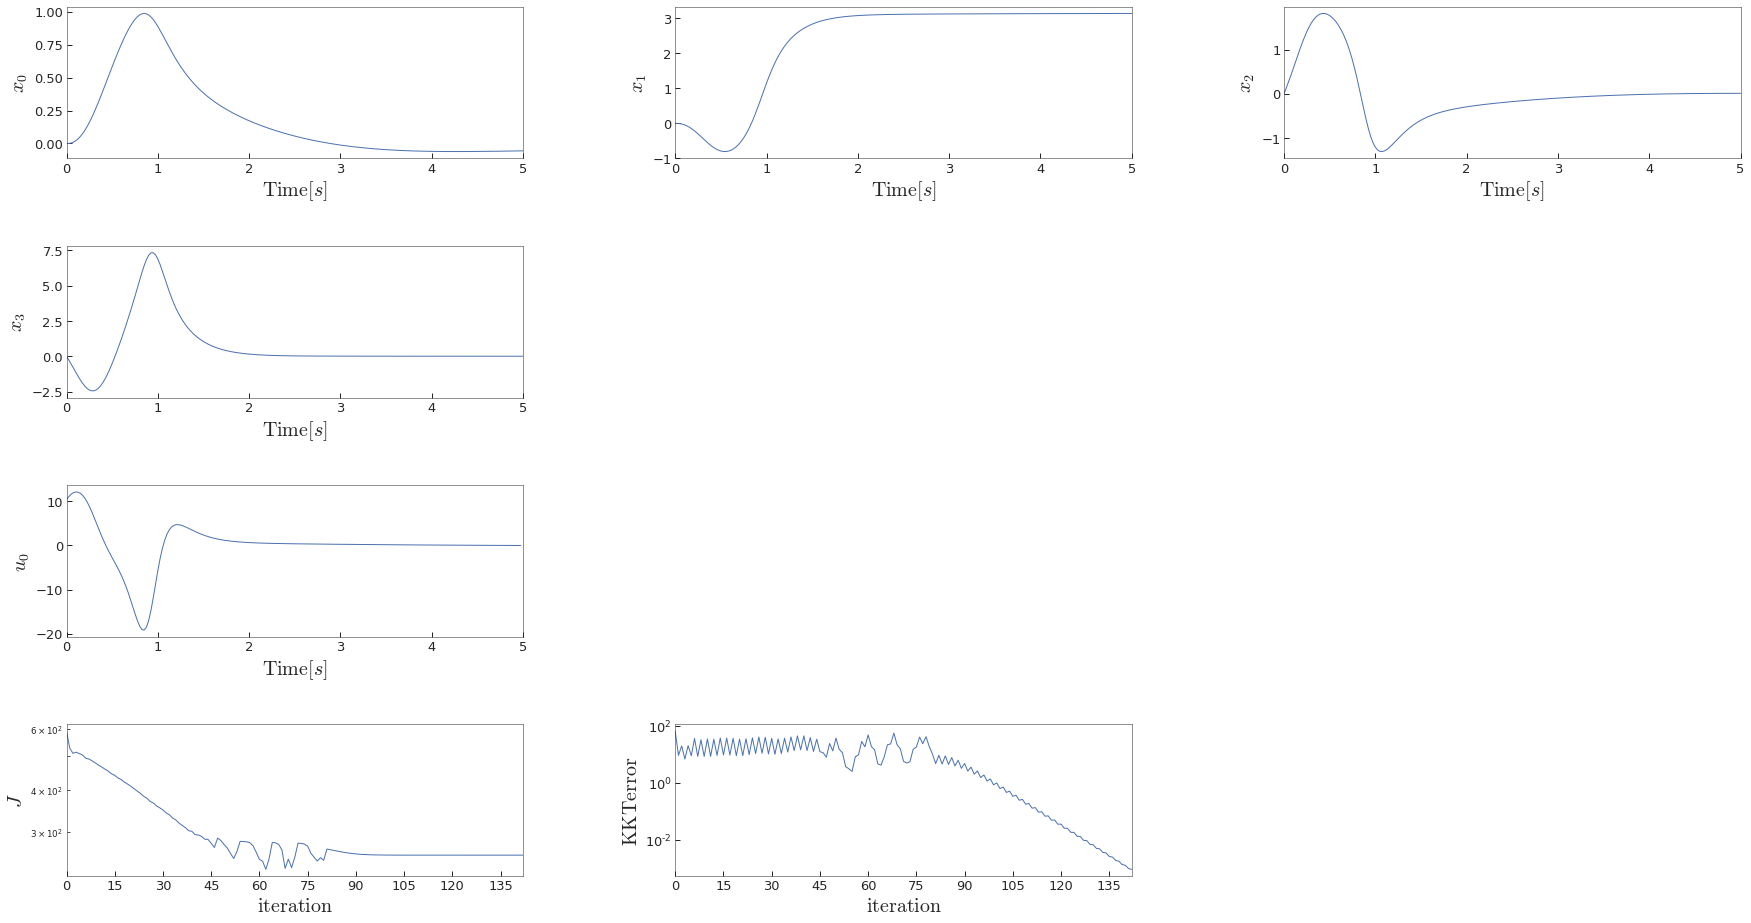

In [22]:
alphas = [0.5**i for i in range(8)]

# set hyperparameters.
solver.set_alphas(alphas)
solver.set_regularization_coeff(gamma_init=1e-3, rho_gamma=5.0, gamma_min=0.0, gamma_max=1e6)
solver.set_stop_tol(kkt_tol=1e-3)
solver.set_max_iters(1000)

# Solve ocp
xs, us, ts, is_success = solver.solve(result=True, log=True, plot=True, gamma_fixed=0.0)


In [23]:
xs

array([[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000],
       [ 2.50043426e-130,  2.50043426e-130,  1.29353388e-001,
        -2.58706776e-001],
       [ 3.23383470e-003, -6.46766940e-003,  2.67584668e-001,
        -5.35169335e-001],
       [ 9.92345139e-003, -1.98469028e-002,  4.12426877e-001,
        -8.21676409e-001],
       [ 2.02341233e-002, -4.03888130e-002,  5.61511715e-001,
        -1.11005642e+000],
       [ 3.42719162e-002, -6.81402235e-002,  7.12363120e-001,
        -1.39171462e+000],
       [ 5.20809942e-002, -1.02933089e-001,  8.62398453e-001,
        -1.65770341e+000],
       [ 7.36409555e-002, -1.44375674e-001,  1.00895037e+000,
        -1.89887351e+000],
       [ 9.88647148e-002, -1.91847512e-001,  1.14932057e+000,
        -2.10614665e+000],
       [ 1.27597729e-001, -2.44501178e-001,  1.28087091e+000,
        -2.27092731e+000],
       [ 1.59619502e-001, -3.01274361e-001,  1.40114791e+000,
        -2.38563085e+000],
       [ 1.94648199e-

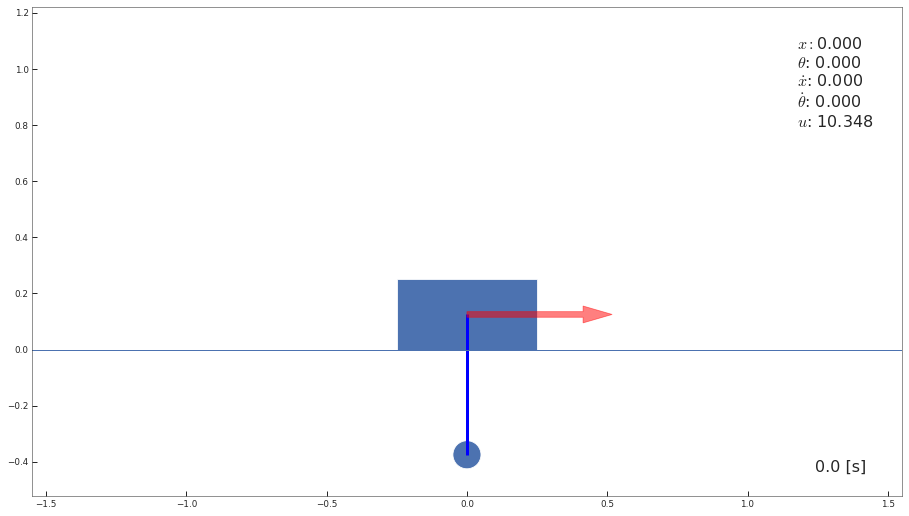

In [24]:
%matplotlib inline
# Visualize
from ocpy.animator import CartPoleAnimator
animator = CartPoleAnimator(solver.get_log_directory(), sim_name)
animator.generate_animation(False)


In [25]:
print('xs\n', xs)
print('us\n', us)


xs
 [[ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000]
 [ 2.50043426e-130  2.50043426e-130  1.29353388e-001 -2.58706776e-001]
 [ 3.23383470e-003 -6.46766940e-003  2.67584668e-001 -5.35169335e-001]
 [ 9.92345139e-003 -1.98469028e-002  4.12426877e-001 -8.21676409e-001]
 [ 2.02341233e-002 -4.03888130e-002  5.61511715e-001 -1.11005642e+000]
 [ 3.42719162e-002 -6.81402235e-002  7.12363120e-001 -1.39171462e+000]
 [ 5.20809942e-002 -1.02933089e-001  8.62398453e-001 -1.65770341e+000]
 [ 7.36409555e-002 -1.44375674e-001  1.00895037e+000 -1.89887351e+000]
 [ 9.88647148e-002 -1.91847512e-001  1.14932057e+000 -2.10614665e+000]
 [ 1.27597729e-001 -2.44501178e-001  1.28087091e+000 -2.27092731e+000]
 [ 1.59619502e-001 -3.01274361e-001  1.40114791e+000 -2.38563085e+000]
 [ 1.94648199e-001 -3.60915132e-001  1.50802524e+000 -2.44425781e+000]
 [ 2.32348830e-001 -4.22021577e-001  1.59983918e+000 -2.44290391e+000]
 [ 2.72344810e-001 -4.83094175e-001  1.67548827e+000 -2.38008471e+000]
 [

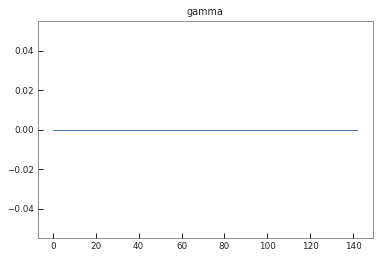

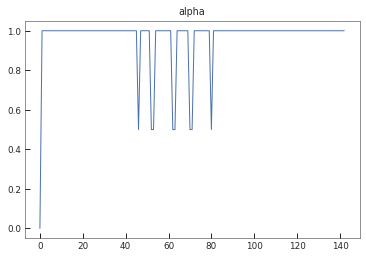

average alpha: 0.9718309859154919


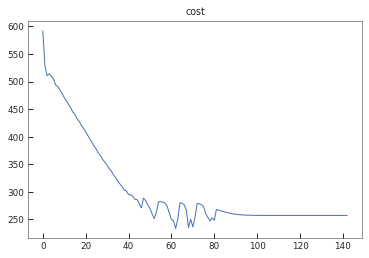

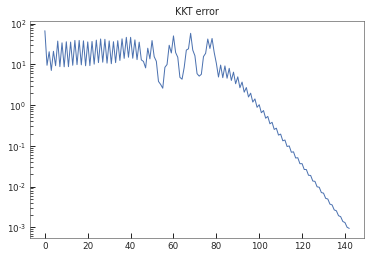

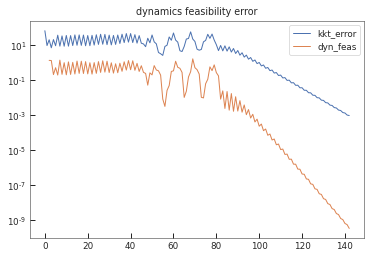

In [26]:
result = solver.get_result()
gamma_hist = result['gamma_hist']

import matplotlib.pyplot as plt
import math

plt.plot(gamma_hist)
plt.title('gamma')
plt.show()

alpha_hist = result['alpha_hist']
plt.plot(alpha_hist)
plt.title('alpha')
plt.show()
print('average alpha:',sum(alpha_hist / (len(alpha_hist) - 1)))

cost_hist = result['cost_hist']
plt.plot(cost_hist)
plt.title('cost')
plt.show()

kkt_error_hist = result['kkt_error_hist']
plt.yscale('log')
plt.plot(kkt_error_hist)
plt.title('KKT error')
plt.show()

dyn_feas_hist = result['dyn_feas_hist']
dyn_feas_hist = np.where(dyn_feas_hist < 1e-20, np.nan, dyn_feas_hist)
plt.yscale('log')
plt.plot(kkt_error_hist, label='kkt_error')
plt.plot(dyn_feas_hist, label='dyn_feas')
plt.legend()
plt.title('dynamics feasibility error')
plt.show()
